In [201]:
from typing import NamedTuple, Callable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.color import label2rgb
from skimage.filters import gaussian
from skimage.measure import label, regionprops
from skimage.measure._regionprops import RegionProperties
from skimage.morphology import flood, watershed
from skimage.segmentation import clear_border, random_walker

from spine_detector.core import FilterUnit, ThresholdFilterUnit

from scipy import ndimage as ndi

In [4]:
from spine_detector.masking.gradient import box_filtering_via_gauss
from spine_detector.utils import load_mri, to_uint8
path = '../test-data/0001/T2_TSE_SAG_384_0002'
original_data = load_mri(path)

data = np.array([to_uint8(array.pixel_array) for array in original_data])

In [5]:
core_1 = FilterUnit()
core_1.set_original_data(data)
core_2 = FilterUnit()
core_2.set_original_data(data)
core_3 = ThresholdFilterUnit()
core_3.set_original_data(data)

In [207]:
filtration_big_box_params = {
    'infl_k': 0.9,
    'grad_degree': 0.9,
    'alpha': 0.2,
    'x': 1.16,
    'y': 1.82,
    'z': 2.73,
    'k_min': 5.3,
    'light': 1
}

filtration_small_box_params = {
    'infl_k': 0.9,
    'grad_degree': 1.8,
    'alpha': 0.2,
    'x': 0.1,
    'y': 0.09,
    'z': 0.09,
    'k_min': 12.8,
    'light': 1.
}

threshold_filtration = {
    'threshold': 40
}

segmentation_params = {
    'vert_min_size': 800,
    'vert_max_size': 1200,
    'disk_min_size': 200,
    'disk_max_size': 400,
    'coef': 1.
}
core_1.update_filtration(filtration_small_box_params)
core_2.update_filtration(filtration_big_box_params)
core_3.update_filtration(threshold_filtration)

Run filtration
Start get_gradient
Finished get_gradient in 0:00:00.362618
Start box_filtering_via_gauss
Finished box_filtering_via_gauss in 0:00:00.262257
Start box_filtering_via_gauss
Finished box_filtering_via_gauss in 0:00:00.074800
Arg before log: 0.9346412226331778
Run filtration
Start get_gradient
Finished get_gradient in 0:00:00.428883
Start box_filtering_via_gauss
Finished box_filtering_via_gauss in 0:00:00.326166
Start box_filtering_via_gauss
Finished box_filtering_via_gauss in 0:00:00.087802
Arg before log: 17.976864029585318
{'edge': 40, 'threshold': 40}


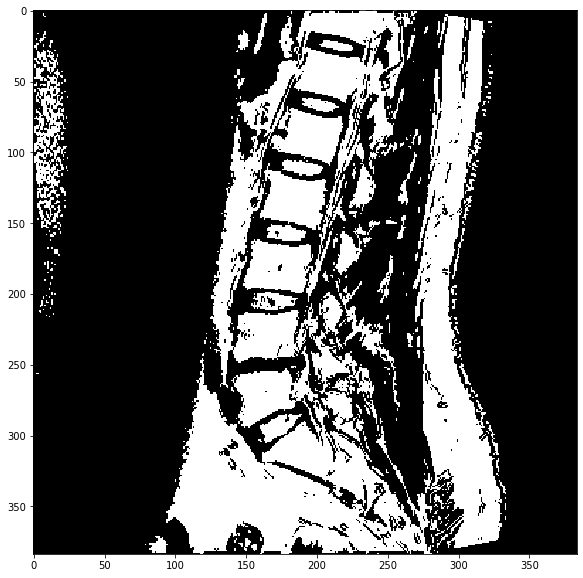

In [209]:
result_mask = core_1.get_filtered_mask() * core_3.get_filtered_mask()
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(result_mask[9], cmap='gray')

In [11]:
from spine_detector.core import ImageSegmentationUnit
segmentation_params = {
    'min_size': 800,
    'max_size': 1200
}
segmentation_unit = ImageSegmentationUnit()

segmentation_unit.set_source_data(result_mask)

segmentation_unit.update_segmentation(segmentation_params)

In [ ]:
slice

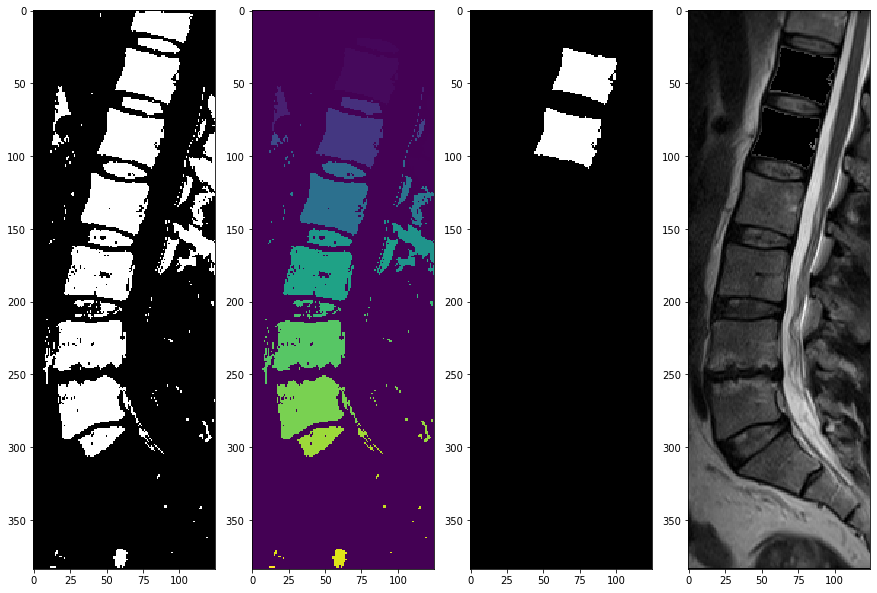

In [158]:
original_image = data[7].copy()
original_image = clear_border(original_image)
tst_result_mask = clear_border(result_mask[7])
original_label = label(tst_result_mask)
stats = np.unique(original_label, return_counts=True)[1]
vert_areas_ids = np.where((stats > 750) * (stats < 1300))
only_vert_image = np.isin(original_label, vert_areas_ids)
delta = 10

fig, ax = plt.subplots(ncols=4, figsize=(15,15))
ax[0].imshow(tst_result_mask[:, 125:250], cmap='gray')
ax[1].imshow(original_label[:, 125:250])
ax[2].imshow(only_vert_image[:, 125:250], cmap='gray')
ax[3].imshow((original_image * (~only_vert_image))[:, 125:250], cmap='gray')


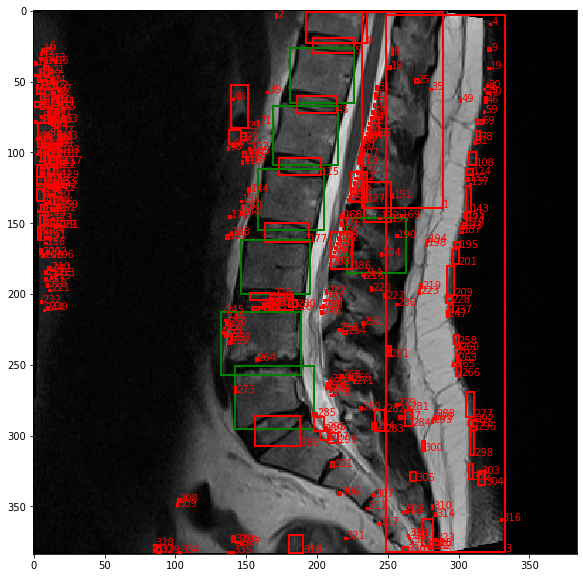

In [246]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(original_image, cmap='gray')
survived_regions = []
another_regions = []
survived_images = []
disk_areas = dict()

range_perimeter_criteria = lambda x, min_area, max_area: min_area < x.perimeter < max_area

for i, region in enumerate(regionprops(original_label, intensity_image=original_image)):
    if region.area > 0:
        if i in [5, 45, 115, 177, 286]:
            disk_areas[i] = region
        minr, minc, maxr, maxc = region.bbox

        y, x = maxr, maxc
        if range_perimeter_criteria(region, 150, 300):
            survived_regions.append(region)

            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='green', linewidth=2)
            ax.add_patch(rect)

        else:
            pass
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.text(x, y, str(i), color='red', fontsize=10)
            ax.add_patch(rect)

Extent: 0.6301994301994301, Perimeter: 155.43250352560273, Filled area: 1106
Extent: 0.6356107660455487, Perimeter: 166.46803743153546, Filled area: 1228
Extent: 0.6462147451756556, Perimeter: 187.16042558696057, Filled area: 1321
Extent: 0.38278388278388276, Perimeter: 225.51576464628795, Filled area: 627
Extent: 0.7185821697099892, Perimeter: 291.2436867076458, Filled area: 1388
Extent: 0.578548644338118, Perimeter: 293.41525958289964, Filled area: 1472
Extent: 0.5633116883116883, Perimeter: 258.75840533340727, Filled area: 1402


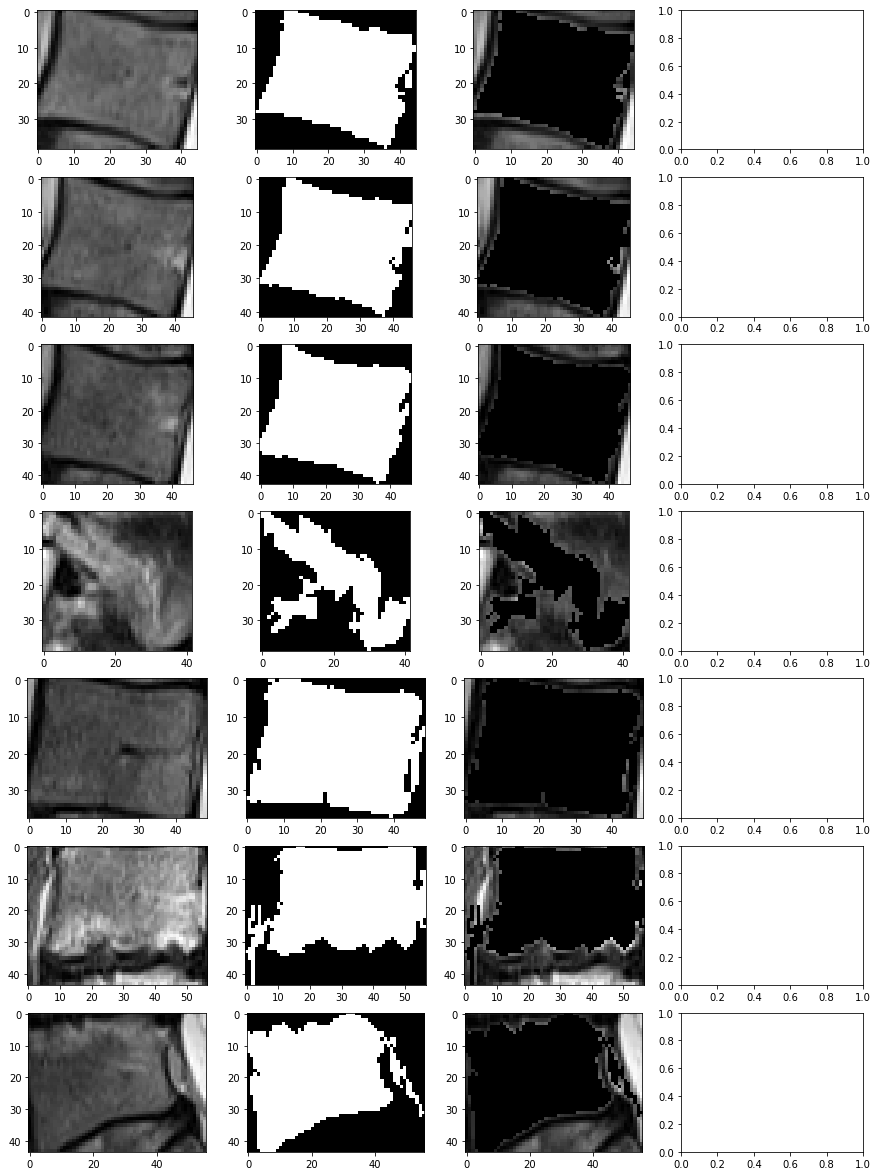

In [245]:
size = len(survived_regions)
fig, ax = plt.subplots(ncols=4, nrows=len(survived_regions), figsize=(15,size * 3))
for i, region in enumerate(survived_regions):
    original_image_region = original_image[region.slice]

    ax[i][0].imshow(original_image_region, cmap='gray')
    ax[i][1].imshow(region.filled_image, cmap='gray')
    ax[i][2].imshow(original_image_region * (~region.filled_image), cmap='gray')
    #ax[i][3].text(0, 1, f'Extent: {region.extent}')
    #ax[i][3].text(0, 1, f'Perimeter: {region.perimeter}')

    print(f'Extent: {region.extent}, Perimeter: {region.perimeter}, Filled area: {region.filled_area}')

Rectangle(xy=(197, 19), width=29, height=11, angle=0)
Rectangle(xy=(186, 60), width=28, height=12, angle=0)
Rectangle(xy=(173, 104), width=30, height=12, angle=0)
Rectangle(xy=(163, 150), width=31, height=13, angle=0)
Rectangle(xy=(156, 286), width=32, height=21, angle=0)


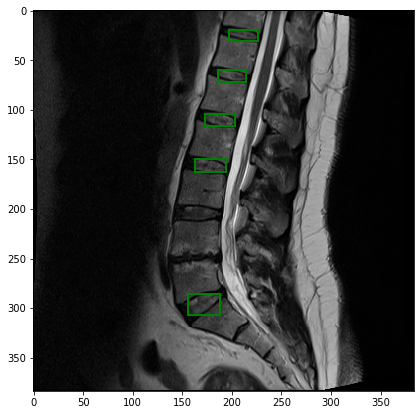

In [223]:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(original_image, cmap='gray')
for i, region in disk_areas.items():
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='green', linewidth=2)
    #ax.text(x, y, str(len(survived_regions) - 1), color='red', fontsize=14)
    ax.add_patch(rect)

67.45584412271572 0.5830721003134797
67.79898987322332 0.6011904761904762
80.76955262170047 0.6277777777777778
106.08326112068522 0.6228287841191067
105.01828996322962 0.5282738095238095


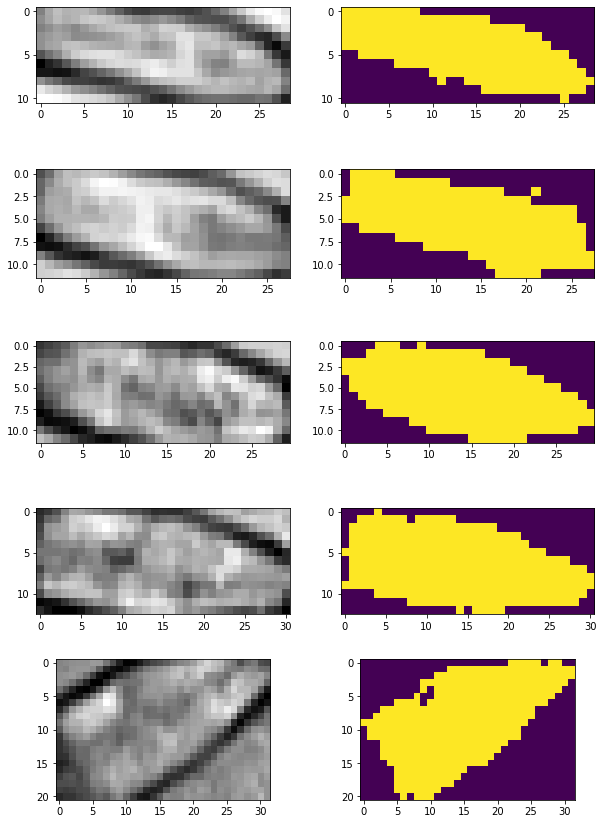

In [231]:
fig, ax = plt.subplots(nrows=len(disk_areas.values()), ncols=2, figsize=(10, 3*len(disk_areas.values())))
for i, region in enumerate(disk_areas.values()):
    ax[i][0].imshow(original_image[region.slice], cmap='gray')
    ax[i][1].imshow(region.filled_image)
    print(region.perimeter, region.extent)
    #ax[i][2].text(0, 15, f'{region.extent}, {region.perimeter}')


In [197]:
good_region = survived_regions[0]
good_region_1 = survived_regions[6]
bad_region = survived_regions[3]
print(good_region.perimeter, good_region.extent, good_region.mean_intensity)
print(good_region_1.perimeter, good_region_1.extent, good_region_1.mean_intensity)
print(bad_region.perimeter, bad_region.extent, good_region.mean_intensity)

155.43250352560273 0.6301994301994301 76.48915009041592
258.75840533340727 0.5633116883116883 64.05547550432277
225.51576464628795 0.38278388278388276 76.48915009041592


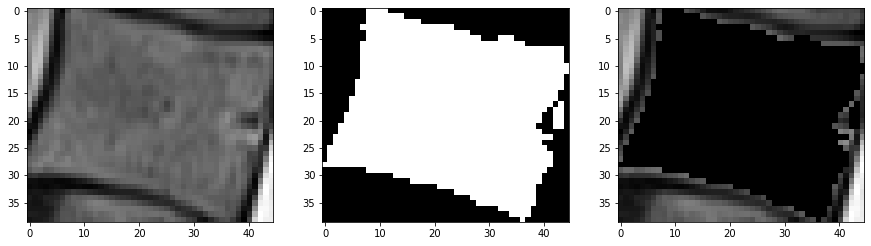

In [184]:
tst_region = survived_regions[0]
original_image_region = original_image[tst_region.slice]
_, ax = plt.subplots(ncols=3, figsize=(15,10))
ax[0].imshow(original_image_region, cmap='gray')
ax[1].imshow(tst_region.filled_image, cmap='gray')
ax[2].imshow(original_image_region * (~tst_region.filled_image), cmap='gray')

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
a = ax.imshow(original_image[140:240, 120:240], cmap='gray')
ax.axis('off')

In [ ]:

def inflate(mask, radius):
    mask = mask.astype(np.float)
    mask = box_filtering_via_gauss(mask, degree=1, size=(radius,) * 3) + 1e-10
    print(np.sum(mask))
    print(np.sum(mask ** 2))
    #coef = np.sum()
    
    mask =  np.log(mask * (np.power(radius * np.sqrt(2*np.pi), 3) * 0.85))
    mask = np.sqrt(-mask * 2)* radius
    return mask >= radius

one_pixel_array = np.zeros((30, 30, 30), dtype=np.dtype)
one_pixel_array[15, 15, 15] = 1.

result = inflate(one_pixel_array, 5)

a = plt.imshow(result[15], cmap='gray')
#plt.colorbar(a)
plt.show()

print(result[15, 15, 15])